In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ucfcrimeminidataset/dataset/Assault/Assault002_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Assault/Assault018_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Assault/Assault045_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Assault/Assault011_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Assault/Assault029_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Assault/Assault033_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Assault/Assault051_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Arrest/Arrest015_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Arrest/Arrest042_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Arrest/Arrest043_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Arrest/Arrest033_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Arrest/Arrest030_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Arrest/Arrest029_x264.mp4
/kaggle/input/ucfcrimeminidataset/dataset/Arrest/Arrest011_x264.mp4
/kaggle/input/ucfcrimeminidataset/

In [1]:
import tensorflow as tf
from tensorflow import keras
import ipywidgets
import os
import io
import matplotlib.pyplot as plt
import cv2
import imageio
#import medmnist
#import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2 as cv

# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
np.random.seed(SEED)

In [3]:
# DATA
DATASET_NAME = "UCF-Crime-mini"
BATCH_SIZE = 128
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (15, 100, 100, 1)
NUM_CLASSES = 13
TRAIN_RATIO = 0.7
TEST_RATIO = 0.25
VALIDATION_RATIO = 0.05

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 60

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

In [8]:
ROOT_PATH = "/kaggle/input/ucfcrimeminidataset/dataset"

Abuse_PATH = ROOT_PATH + '/Abuse'
Arrest_PATH = ROOT_PATH + '/Arrest'
Assault_PATH = ROOT_PATH + '/Assault'
Burglary_PATH = ROOT_PATH + '/Burglary'
Fighting_PATH = ROOT_PATH + '/Fighting'
Normal_PATH = ROOT_PATH + '/normal'



OUT_PATH = "/kaggle/working/out/vivit-ucf-mini/"

In [11]:
def extract_frames(directory, dimensions=(INPUT_SHAPE[1], INPUT_SHAPE[2]), packet_length = INPUT_SHAPE[0], save_dir_path = None):
    data = []

    for video_name in os.listdir(directory):
        video = cv2.VideoCapture(directory + '/' + video_name)
        packet = []
        while video.isOpened():
            ret, frame = video.read()

            if not ret: # no more frames
                break

            del ret

            # capturing the frame

            frame = cv2.resize(frame, dimensions, interpolation = cv2.INTER_AREA)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            packet.append(frame)
            del frame

            if len(packet) == packet_length: 
                '''
                consecutive packets share 14 of the 15 frames to generate more data
                '''
                # packet itself is not normalized
                stacked = np.array(packet) # convert to numpy and normalize packet
                data.append(stacked.copy()) # this .copy() is not in the original code 
                del packet
                packet = []


        video.release()
        #cv2.destroyAllWindows()

    del packet
    # TODO: read the docs for the next 2 lines
    data = np.stack(data, axis= 0)
#     data = np.moveaxis(data, 1 ,-1)

    # save to disk
    if(save_dir_path is not None):
        np.save(f'{save_dir_path}/data', data)

    return data

In [12]:
normal_frames = extract_frames(Normal_PATH)
print(normal_frames.shape)

(1282, 15, 100, 100)


In [13]:
abuse_frames    = extract_frames(Abuse_PATH)

In [14]:
arrest_frames   = extract_frames(Arrest_PATH)

In [15]:
assault_frames  = extract_frames(Assault_PATH)

In [16]:
burglary_frames = extract_frames(Burglary_PATH)

In [17]:
fighting_frames = extract_frames(Fighting_PATH)

(-0.5, 99.5, 99.5, -0.5)

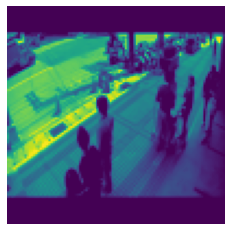

In [18]:
plt.imshow(normal_frames[0][1])
plt.axis('off')

In [19]:
print(abuse_frames.shape)


(1374, 15, 100, 100)


In [20]:
abuse_labels = np.full((abuse_frames.shape[0]), 0)

In [21]:
arrest_labels = np.full((arrest_frames.shape[0]), 1)

In [22]:
assault_labels = np.full((assault_frames.shape[0]), 2)

In [23]:
burglary_labels = np.full((burglary_frames.shape[0]), 3)

In [24]:
fighting_labels = np.full((fighting_frames.shape[0]), 4)

In [25]:
normal_labels = np.full((normal_frames.shape[0]), 5)

In [26]:
x = np.concatenate((normal_frames,abuse_frames, arrest_frames, assault_frames, burglary_frames, fighting_frames))
print(x.shape)

(9553, 15, 100, 100)


In [27]:
y = np.concatenate((normal_labels,abuse_labels, arrest_labels, assault_labels, burglary_labels, fighting_labels))
print(np.unique(y))

[0 1 2 3 4 5]


In [28]:
import gc
for i in range(100):
    gc.collect()

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
 x, y, test_size=0.3, random_state=42, stratify = y)

X_test, X_validate, y_test, y_validate = train_test_split(
 X_test, y_test, test_size=0.2, random_state=42, stratify = y_test)

In [30]:
print( X_train.shape, X_test.shape, X_validate.shape, y_train.shape, y_test.shape, y_validate.shape)

(6687, 15, 100, 100) (2292, 15, 100, 100) (574, 15, 100, 100) (6687,) (2292,) (574,)


0 (6687, 15, 100, 100)


(-0.5, 99.5, 99.5, -0.5)

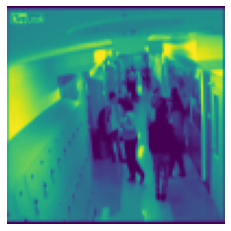

In [31]:
print(y_train[3], X_train.shape)
plt.imshow(X_train[3][0])
plt.axis('off')

In [32]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [33]:
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, list_IDs, labels,
                 to_fit=True, batch_size=128, dim=(15, 100, 100),
                 n_channels=1, n_classes=13, shuffle=True):
        self.list_IDs = list_IDs
        self.labels = labels
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X = self._generate_X(list_IDs_temp)

        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        else:
            return X

    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def _generate_X(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i,] = self._load_grayscale_image(self.image_path + self.labels[ID])

        return X

    def _generate_y(self, list_IDs_temp):
        """Generates data containing batch_size masks
        :param list_IDs_temp: list of label ids to load
        :return: batch if masks
        """
        y = np.empty((self.batch_size, *self.dim), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            y[i,] = self._load_grayscale_image(self.mask_path + self.labels[ID])

        return y
training_generator = DataGenerator(X_train, y_train)
validation_generator = DataGenerator(X_validate, y_validate)

In [34]:
len(training_generator)

52

In [35]:
X_validate.shape, y_train.shape

((574, 15, 100, 100), (6687,))

In [36]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

In [38]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 183.2 kB/s eta 0:00:00a 0:00:01


In [42]:
import einops
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


class FeedForwardBlock(tf.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.):
        self.net = keras.Sequential(
            [
                layers.Linear(units=hidden_dim),
                tf.nn.gelu,
                layers.Dropout(rate=dropout),
                layers.Linear(units=embed_dim),
                layers.Dropout(rate=dropout),
            ])

    def __call__(self, inputs):
        x = self.net(inputs)
        return x


class FSAttention(tf.Module):
    def __init__(self, embed_dim, dim_head, num_heads, dropout=0.0):
        self.embed_dim = embed_dim
        self.inner_dim = dim_head * num_heads
        self.dim_head = dim_head
        self.num_heads = num_heads
        self.dropout = dropout
        project_out = not (num_heads == 1 and dim_head == embed_dim)

        self.scale = dim_head ** -0.5
        self.to_qkv = layers.linear(embed_dim * 3, use_bias=False)
        self.to_out = keras.Sequential(
            [
                layers.linear(embed_dim),
                layers.Dropout(dropout),
            ]) if project_out else tf.identity

    def __call__(self, x):
        _, _, _, h = *x.shape, self.num_heads
        qkv = self.to_qkv(x).reshape(*x.shape[:-1], 3, h, self.dim_head)
        q, k, v = tf.unstack(qkv, axis=-3)
        dots = tf.einsum("...ndh,...mdh->...nmh", q, k) * self.scale
        attn = dots.softmax(dim=-1)
        out = tf.einsum("...nmh,...mdh->...ndh", attn, v)
        out = out.reshape(*x.shape[:-1], self.inner_dim)
        return self.to_out(out)

class FSATransformerBlock(tf.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_dim,nt,nh,nw, dropout=0.0):
        self.layers = []
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(tf.ModuleList([
                layers.LayerNorm(epsilon=1e-6),
                FSAttention(embed_dim, embed_dim // num_heads, num_heads, dropout),
                layers.layerNorm(epsilon=1e-6),
                FSAttention(embed_dim, embed_dim // num_heads, num_heads, dropout),
                layers.LayerNorm(epsilon=1e-6),
                FeedForwardBlock(embed_dim, mlp_dim, dropout),
            ]))

    def __call__(self, x):
        b = x.shape[0]
        x = x.flatten(2)
        for _, attn1,_, attn2,_, ff in self.layers:
            x1 = x + attn1(x) # spatial attention
            x1 = x1.reshape(b,self.nt,self.nh,self.nw,0)
            x1 = [temp[None] for temp in x1]
            x1 = np.concatenate(x1,axis=0).transpose(1,2)

            x2 = x1 + attn2(x1) # temporal attention
            x = ff(x2) + x2 # MLP

            # reshape tensor for spatial attention
            x = x.reshape(b,self.nt,self.nh,self.nw,0)
            x = [temp[None] for temp in x]
            x = np.concatenate(x,axis=0).transpose(1,2)
            x = x.flatten(2)

        x = x.reshape((b,self.nt*self.nh*self.nw,-1))
        x = [temp[None] for temp in x]
        x = np.concatenate(x,axis=0).flatten(2)
        return x
        
class FDAttention(tf.Module):
  def __init__(self, dim, nt, nh, nw, heads=8, dim_head=64, dropout=0.0):
    inner_dim = dim_head * heads
    self.nt = nt
    self.nh = nh
    self.nw = nw
    self.heads = heads
    self.scale = dim_head ** -0.5
    project_out = not (heads == 1 and dim_head == dim)
    self.attend = layers.Softmax(axis=-1)
    self.to_qkv = layers.linear(inner_dim * 3, use_bias=False)
    self.to_out = layers.Sequential(
            [
                layers.linear(inner_dim),
                layers.Dropout(dropout),
            ]) if project_out else tf.identity
    def forward(self, x):
        b, n, d, h = *x.shape, self.heads
        qkv = self.to_qkv(x).reshape(*x.shape[:-1], 3, h, self.dim_head)      
        q, k, v = tf.unstack(qkv, axis=-3)
        qs, qt = tf.split(q,2,axis =1)
        ks, kt = tf.split(k,2,axis =1)
        vs, vt = tf.split(v,2,axis =1)

        qs = tf.reshape(qs,[b, h // 2, self.nt, self.nh * self.nw])
        ks = tf.reshape(ks,[b, h // 2, self.nt, self.nh * self.nw])
        vs = tf.reshape(vs,[b, h // 2, self.nt, self.nh * self.nw])

        spatial_dots = tf.einsum("...ndh,...mdh->...nmh", qs, ks) * self.scale
        sp_attn = self.attend(spatial_dots)
        spatial_out = tf.einsum("...nmh,...mdh->...ndh", sp_attn, vs)

        qt = tf.reshape(qt,[b, h // 2, self.nh, self.nw * self.nt])
        kt = tf.reshape(kt,[b, h // 2, self.nh, self.nw * self.nt])
        vt = tf.reshape(vt,[b, h // 2, self.nh, self.nw * self.nt])

        temporal_dots = tf.einsum("...ndh,...mdh->...nmh", qt, kt) * self.scale
        temporal_attn = self.attend(temporal_dots)
        temporal_out = tf.einsum("...nmh,...mdh->...ndh", temporal_attn, vt)
class FDATransformerEncoder(tf.Module):
  def __init__(self, dim, depth, heads, dim_head, mlp_dim, nt, nh, nw, dropout=0.0):
        self.layers = []
        self.nt = nt
        self.nh = nh
        self.nw = nw

        for _ in range(depth):
            self.layers.append(tf.ModuleList([
                layers.LayerNorm(epsilon=1e-6),
                FDAttention(dim, nt, nh, nw, heads=heads, dim_head=dim_head, dropout=dropout)
            ]))
  def forward(self, x):
        for _, attn in self.layers:
            x = attn(x) + x

        return x         

class VIVITBackbone(tf.Module):
    def __init__(self, t, h, w, patch_t, patch_h, patch_w, num_classes, embed_dim, depth, num_heads, mlp_dim, dim_head = 3, dropout=0.0, channels=3, emb_dropout=0.0):
        assert (t, h, w) % (patch_t, patch_h, patch_w) == 0, "Image dimensions must be divisible by the patch size."

        self.patch_t = patch_t
        self.patch_h = patch_h
        self.patch_w = patch_w
        self.channels = channels
        self.t = t
        self.h = h
        self.w = w

        self.nt = t // patch_t
        self.nh = h // patch_h
        self.nw = w // patch_w

        tubelet_dim = (patch_t * patch_h * patch_w) * channels
        self_to_tubelet = layers.Sequential(
            [
                einops.rearrange('b c (t pt) (h ph) (w pw) -> b t (h w) (pt ph pw c)', pt=patch_t, ph=patch_h, pw=patch_w),
                layers.linear(embed_dim),
            ]
        )
        self.pos_embedding = layers.Parameter(tf.random.normal((1,1, self.nh * self.nw, embed_dim)).repeat(1,self.nt,1,1))
        self.dropout = layers.Dropout(emb_dropout)
        assert num_heads % 2 == 0, "num_heads must be divisible by 2."
        self.transformer = FSATransformerBlock(embed_dim, depth, num_heads, mlp_dim, self.nt, self.nh, self.nw, dropout)
        self.to_latent = layers.Identity()
        self.mlp_head = keras.Sequential(
            [
                layers.LayerNorm(epsilon=1e-6),
                layers.linear(num_classes),
            ]
        )

    def __call__(self, x):
        tokens = self.self_to_tubelet(x)
        tokens = tokens + self.pos_embedding
        tokens = self.dropout(tokens)
        x = self.transformer(tokens)
        x = x.mean(dim=1)
        x = self.to_latent(x)
        return self.mlp_head(x)

In [40]:
device = tf.device('cpu')

2022-12-30 18:38:52.015965: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [44]:
vivit = VIVITBackbone(32, 64, 64, 8, 4, 4, 10, 512, 6, 10, 8).to(device)

TypeError: unsupported operand type(s) for %: 'tuple' and 'tuple'